Initialisation

In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 957 kB 7.8 MB/s 
     |████████████████████████████████| 9.3 MB 32.0 MB/s 
     |████████████████████████████████| 1.6 MB 58.4 MB/s 
     |████████████████████████████████| 108 kB 60.2 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torchvision 
from torchvision import datasets, models, transforms

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import cv2
import os
import glob 
from skimage import io 
import random 
%matplotlib inline

from PIL import Image
from numpy import asarray

import time
import pickle

import pennylane as qml
import copy
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4               # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights


Pre-processing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_transforms =transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = '/content/drive/MyDrive/Projects/qBITS/Pneumonia/chest_xray'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms) for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, drop_last=True) for x in ['train', 'val','test']}

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Visualization

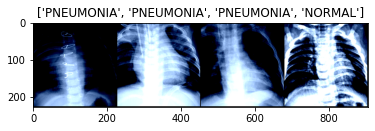

In [ ]:
#Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Variational Circuit

In [ ]:
dev = qml.device('default.qubit', wires=4)
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])

def U_gate(w):

  qml.RX(w[0],wires=0)
  qml.RX(w[2],wires=2)
  qml.RX(w[3],wires=3)

  qml.CNOT(wires=[1,0])

  qml.RY(w[1],1)

  qml.CNOT(wires=[3,0])


def encoding_layer(f,w,nqubits):

  for i in range(nqubits):
    qml.RY(f[i],i)
    qml.Barrier(wires=[0,1,2,3])
    U_gate(w)
    qml.Barrier(wires=[0,1,2,3])
        

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth+1, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    qml.Barrier(wires=range(n_qubits))
    # Embed features in the quantum node
    encoding_layer(q_input_features,q_weights[0],n_qubits)


    # Sequence of trainable variational layers
    for k in range(q_depth):
        qml.Barrier(wires=range(n_qubits))
        entangling_layer(n_qubits)
        qml.Barrier(wires=range(n_qubits))
        encoding_layer(q_input_features,q_weights[k+1],n_qubits)

    # Expectation values in the Z basis
    qml.Barrier(wires=range(n_qubits))
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn((q_depth+1) * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        
        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)


In [ ]:
model_hybrid = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in model_hybrid.parameters():
    param.requires_grad = False
# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

model_hybrid = model_hybrid.to(device)

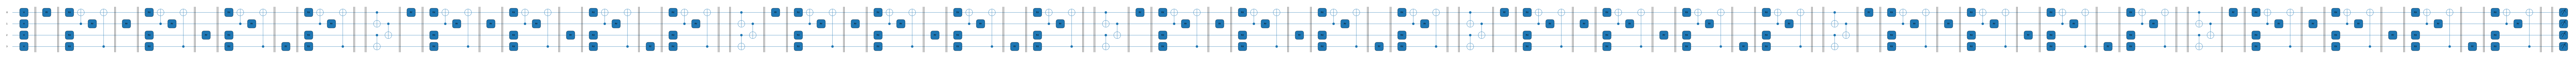

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.

            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                
                print(f"Phase: {phase} Epoch: {epoch + 1}/{num_epochs} Iter: {it + 1}/{n_batches + 1} Batch time: {time.time() - since_batch:.4f}")
                it += 1
                
            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    'train' if phase == 'train' else 'val',
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == 'train' and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == 'train' and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == 'train':
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/3 Iter: 1/1305 Batch time: 1.0969
Phase: train Epoch: 1/3 Iter: 2/1305 Batch time: 1.1069
Phase: train Epoch: 1/3 Iter: 3/1305 Batch time: 1.1160
Phase: train Epoch: 1/3 Iter: 4/1305 Batch time: 1.1055
Phase: train Epoch: 1/3 Iter: 5/1305 Batch time: 1.1181
Phase: train Epoch: 1/3 Iter: 6/1305 Batch time: 1.1097
Phase: train Epoch: 1/3 Iter: 7/1305 Batch time: 1.1331
Phase: train Epoch: 1/3 Iter: 8/1305 Batch time: 1.1314
Phase: train Epoch: 1/3 Iter: 9/1305 Batch time: 1.1082
Phase: train Epoch: 1/3 Iter: 10/1305 Batch time: 1.1348
Phase: train Epoch: 1/3 Iter: 11/1305 Batch time: 1.1419
Phase: train Epoch: 1/3 Iter: 12/1305 Batch time: 1.1210
Phase: train Epoch: 1/3 Iter: 13/1305 Batch time: 1.6640
Phase: train Epoch: 1/3 Iter: 14/1305 Batch time: 1.6106
Phase: train Epoch: 1/3 Iter: 15/1305 Batch time: 1.1232
Phase: train Epoch: 1/3 Iter: 16/1305 Batch time: 1.1026
Phase: train Epoch: 1/3 Iter: 17/1305 Batch time: 1.1370
Phase: train Epoch: 1/